In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

# The Tips Dataset

A waiter maintained a record of his tips, total bill, and information about the person who paid the bill.

In [3]:
data = sns.load_dataset("tips")
print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Why did the waiter collect this information? 

Perhaps the waiter was interested in:

1. **Predicting** the tip as a function of the bill, time of day, day of the week, or information about the table.
1. **Infering** the relationships between tips and other factors.  For example, does the **percent tip** decrease or increase with bill size?

We build models to help answer both of these questions.


# What do we do before we build models?

---
<br/><br/><br/>

# EDA: Tip Distribution

Let's take a closer look at the tip data

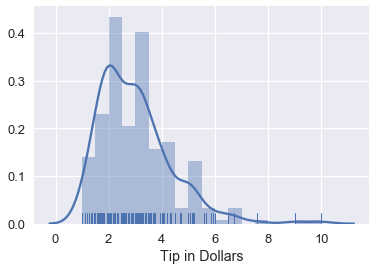

In [4]:
sns.distplot(data['tip'], rug=True)
plt.xlabel("Tip in Dollars")
plt.savefig("tip_in_dollars.pdf")

### What do we observe?

1. The distribution is skewed right.
1. There are a few large tip values (perhaps big bills?) 
1. There appears to be a mode around $2.00.  Perhaps there is a tradition of tipping 2 dollars for small meals (e.g., coffee?)
1. Everyone provided a tip.

---
<br/> <br/> <br/>

# EDA: Bill Distribution

We also plot the total bills.

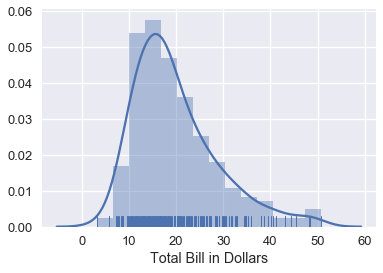

In [5]:
sns.distplot(data['total_bill'], rug=True)
plt.xlabel("Total Bill in Dollars")
plt.savefig("bill.pdf")

### What do we observe?

1. Like tips we see that the distribution is skewed right.
1. The distribution also appears much smoother.  with a clear single mode around $15.

---
<br/><br/><br/>


# EDA: Derived Variable  _Percent Tip_

In many countries it is common to tip a percentage of the bill.  

$$\Large
\texttt{pcttip} = \frac{\texttt{tip}}{\texttt{totalbill}} * 100
$$

However, the exact percentage varies by region, dining environment, and service quality.  

**Question?** What is the percentage tip that this waiter receives?  This will be our first estimation goal.  

We will extend our data with an additional **derived variable** containing the **percent tip**: 

In [6]:
data['pcttip'] = data['tip']/data['total_bill'] * 100

Examining it's distribution we see:

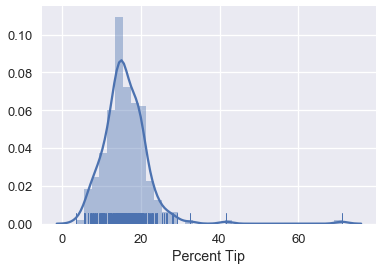

In [7]:
sns.distplot(data['pcttip'], rug=True)
plt.xlabel("Percent Tip")
plt.savefig("percent_tip.pdf")

There are some **large outliers** that are skewing the plot. Why?  What might be an explanation?

In [8]:
text = ["bill $" + str(bill) + ", tip $" + str(tip) for 
        (bill,tip) in data[['total_bill', 'tip']].itertuples(index=False)]
py.iplot(ff.create_distplot([data['pcttip']], group_labels=["Percent Tip"], 
                            rug_text=[text]))

We can try to remove the outliers to get a better picture.

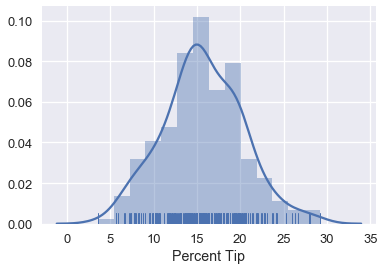

In [9]:
pcttips = data['pcttip']
# Removing data points that are greater than the 99% quantile
sns.distplot(pcttips[pcttips < pcttips.quantile(0.99)], rug=True)
plt.xlabel("Percent Tip")
plt.savefig("percent_tip.pdf")

In [10]:
pcttips = data['pcttip']
# Removing data points that are greater than the 99% quantile
# sns.distplot(pcttips[pcttips < pcttips.quantile(0.99)], rug=True)
py.iplot(ff.create_distplot([pcttips[pcttips < pcttips.quantile(0.99)]], group_labels=["Percent Tip"], 
                            bin_size=.5))

### Observations?

1. This distribution is more symmetric than before (perhaps slightly skewed to the right) and appears to be centered around $15\%$ which is the customary amount to tip in the United States.
1. How many modes do we see? One and maybe two?  Is this something we would expect (15% or 20% tips?).

---
<br/><br/><br/>


# Defining the Model

Let's begin with the goal of **estimating the percentage tip** that this waiter receives.  The percentage tip could depend on a lot of factors including the time of day, to the characteristics of the patrons, and the service of the waiter.  

However, let's start simple by ignoring these factors and defining the percentage tip as a constant value:

$$\Large
\text{percentage tip} = \theta^*
$$

Here the parameter $\theta^*$ is the true tip rate. We don't know this value but we believe that such a value exists.  The $*$ character indicates that this is the unknown quantity that the universe determines.  I like to remember that the star $*$ quantity is determined by the universe.

Is this model correct? Maybe ... probably not.  However, this model probably provides reasonable predictions about future tips and might provide some insight into common tipping practices.  

How do we estimate the value for $\theta^*$ from our data?  This is the fundamental question of estimation.


---
<br/><br/><br/>

## How do we estimate the parameter $\theta^*$ of our tip model?

There are actually many ways we could estimate this parameter. 
1. 15.0 <-- thats what Wikipedia suggests.
1. Pick a data point at random 
1. Look at the histogram and choose the **mode** for our estimate
1. We could choose the mean for our estimate. This is the balance point of the histogram.
1. We could choose the median for our estimate.

**Which of these strategies is best?**  It depends on our goals.

---
<br/><br/><br/>

# Optimizing an Objective Function

One method to estimate the value for the parameter $\theta^*$ is to define an objective function which characterizes the quality of our choice of $\theta^*$ with respect to the data.  We can then choose the *best* parameter $\theta$ with respect to this objective function. 

**How do we define an objective function?**

Perhaps a natural objective function would penalize parameter values for $\theta^*$ that are inconsistent with the data.


---
<br/><br/><br/>

# Loss Functions

At the core of most estimation procedures is a **loss function** which measures how well a model fits the data.  Suppose we observed a single tip percentage $y$ and our model predicts $\theta$ as our guess for $\theta^*$, then any of the following might be appropriate **loss functions**

1. **Squared Loss** (also known as the $L^2$ loss pronounced "ell-two"):
$$\Large
L\left(\theta, y \right) = \left( y - \theta \right)^2
$$
1. **Absolute Loss** (also known as the $L^1$ loss pronounced "ell-one"):
$$\Large
L\left(\theta, y \right) = \left| y - \theta \right|
$$
1. **Huber Loss** (combines both Squared and Absolute Loss):
$$\Large
L_\alpha\left( \theta, y \right) = 
\begin{cases} 
      \frac{1}{2}\left( y - \theta \right)^2 & \left| y - \theta \right| < \alpha \\
       \alpha \left(\left| y - \theta \right| - \frac{\alpha}{2} \right) & \text{otherwise}
\end{cases}
$$

These loss functions effectively measure the **error** in our estimate relative to the data.  Let's examine how they work on a real observations.

## Visualizing the Loss

Suppose we observe a single tip percentage for $16\%$:

In [11]:
y_obs = 16

We will try a range of possible $\theta$ values

In [12]:
thetas = np.linspace(0, 50, 200)

### Squared Loss 

$$\Large
L\left(\theta, y \right) = \left( y - \theta \right)^2
$$

In [13]:
def squared_loss(est, y_obs):
    return (est - y_obs)**2

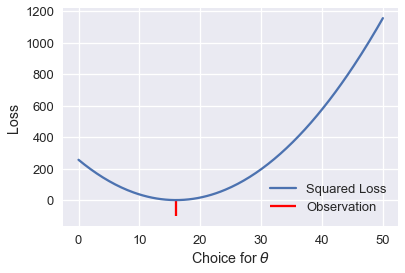

In [14]:
thetas = np.linspace(0, 50, 200)
loss = squared_loss(thetas, y_obs)
plt.plot(thetas, loss, label="Squared Loss")
plt.vlines(y_obs, -100, 0, colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend(loc=4)
plt.savefig("l2_plt.pdf")


From the above plot we see that the value for $\theta$ that minimizes the loss corresponds to $\theta = y = 16\%$.  Let's look at the other loss functions:

### Absolute Loss

$$\Large
L\left(\theta, y \right) = \left| y - \theta \right|
$$

In [15]:
def abs_loss(est, y_obs):
    return np.abs(y_obs - est)

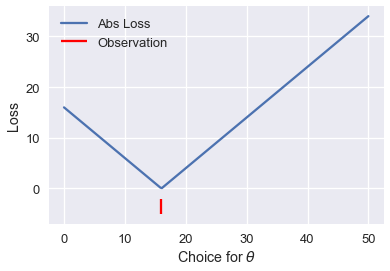

In [16]:
thetas = np.linspace(0, 50, 200)
loss = abs_loss(thetas, y_obs)
plt.plot(thetas, loss, label="Abs Loss")
plt.vlines(y_obs, -5, -2,colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l1_plt.pdf")

Again we see that the loss function is minimized when $\theta = y = 16\%$ = 

### Huber Loss

$$\Large
L_\alpha\left( \theta, y \right) = 
\begin{cases} 
      \frac{1}{2}\left( y - \theta \right)^2 & \left| y - \theta \right| < \alpha \\
       \alpha \left(\left| y - \theta \right| - \frac{\alpha}{2} \right) & \text{otherwise}
\end{cases}
$$

In [17]:
def huber_loss(est, y_obs, alpha = 1):
    d = abs_loss(est, y_obs)
    return np.where(d < alpha, 
                    squared_loss(est, y_obs) / 2.0,
                    alpha * (d - alpha / 2.0))

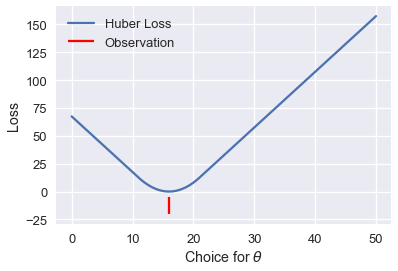

In [18]:
thetas = np.linspace(0, 50, 200)
loss = huber_loss(thetas, y_obs, alpha=5)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(y_obs, -20, -5,colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig('huber_loss.pdf')

### Comparing all the loss functions at once.

In the following plot we plot all three loss functions. 

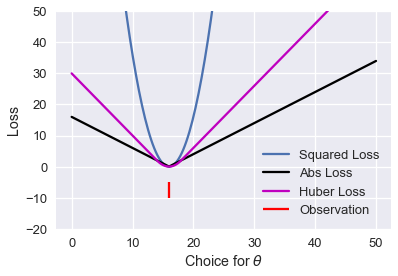

In [19]:
thetas = np.linspace(0, 50, 200)
plt.plot(thetas, squared_loss(thetas, y_obs), label="Squared Loss")
plt.plot(thetas, abs_loss(thetas, y_obs), color='k', label="Abs Loss")
plt.plot(thetas, huber_loss(thetas, y_obs, alpha=2), color='m', label="Huber Loss")
plt.vlines(y_obs, -10, -5, colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.ylim([-20, 50])
plt.legend()
plt.savefig("loss_functions_compared.pdf")

### What do we observe?

1. All the loss functions have the same minimizer.
1. Different shapes around the minimum 
    1. Abs loss is pointy 
    1. Huber and Squared Loss are smooth.
1. Different behavior far away from minimum
    1. Squared loss penalizes errors more than the Abs or Huber loss.

---
<br/><br/><br/>

# Average Loss of the Data

The loss functions we have examined so far define the loss of the model with respect to a single data point.   How can we extend this notion of loss to the entire dataset? 

A simple and intuitive way to extend the loss to the entire dataset is to compute the average loss over all the data points. More formally, let the dataset $\mathcal{D}$ be the set of observations:

$$\Large
\mathcal{D} = \{y_1, \ldots, y_n\}
$$

where $y_i$ correspond to a single tip percentage and there are $n=244$ observations in our dataset.

Then we can define the average loss over the dataset as:

$$\Large
L\left(\theta, \mathcal{D}\right) = \frac{1}{n} \sum_{i=1}^n L(\theta, y_i)
$$


## Plotting the Average Loss

In [20]:
def avg_loss(loss, est, data):
    return np.mean(np.array([loss(est, y_obs) for y_obs in data]), axis=0)

### Average Squared Loss

Minimizing Theta 16.0804020101


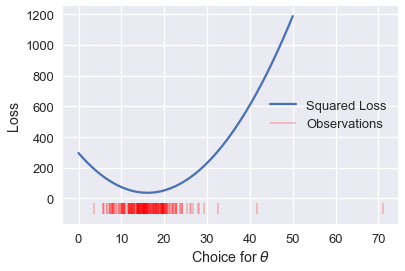

In [21]:
thetas = np.linspace(0, 50, 200)
loss = avg_loss(squared_loss, thetas, data['pcttip'])
plt.plot(thetas, loss, label="Squared Loss")
plt.vlines(data['pcttip'], -100, -30, colors="r", linewidth=0.4, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend(loc=5)
print("Minimizing Theta", thetas[np.argmin(loss)])
plt.savefig("l2_avg_loss.pdf")

### Average Absolute Loss

Minimizing Theta 15.5778894472


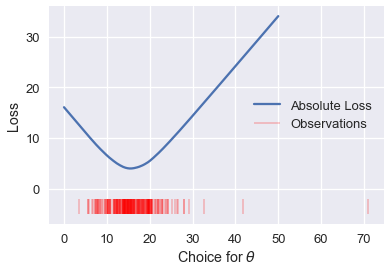

In [22]:
thetas = np.linspace(0, 50, 200)
loss = avg_loss(abs_loss, thetas, data['pcttip'])
plt.plot(thetas, loss, label="Absolute Loss")
plt.vlines(data['pcttip'], -5, -2, colors="r", linewidth=0.4, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend(loc=5)
print("Minimizing Theta", thetas[np.argmin(loss)])
plt.savefig("l1_avg_loss.pdf")

### Average Huber

Minimizing Theta 15.5778894472


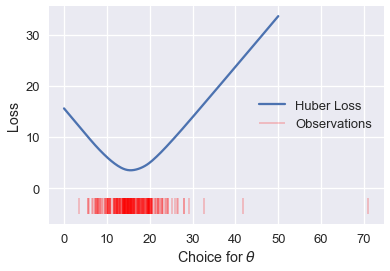

In [23]:
thetas = np.linspace(0, 50, 200)
loss = avg_loss(huber_loss, thetas, data['pcttip'])
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(data['pcttip'], -5, -2, colors="r", linewidth=0.4, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend(loc=5)
print("Minimizing Theta", thetas[np.argmin(loss)])
plt.savefig("huber_avg_loss.pdf")

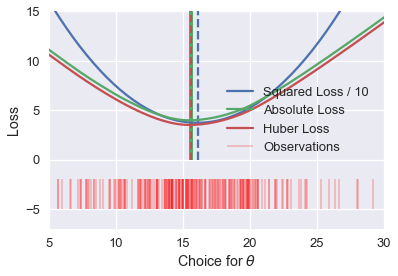

In [24]:
thetas = np.linspace(0, 50, 200)
a = plt.plot(thetas, avg_loss(squared_loss, thetas, data['pcttip'])/10, label="Squared Loss / 10 ")
plt.vlines(thetas[np.argmin(avg_loss(squared_loss, thetas, data['pcttip']))], 0, 20, linestyle='--',
           color = a[0].get_color())
a = plt.plot(thetas, avg_loss(abs_loss, thetas, data['pcttip']), label="Absolute Loss")
plt.vlines(thetas[np.argmin(avg_loss(abs_loss, thetas, data['pcttip']))], 0, 20,
           color = a[0].get_color(),linewidth=4)
a = plt.plot(thetas, avg_loss(huber_loss, thetas, data['pcttip']), label="Huber Loss")
plt.vlines(thetas[np.argmin(avg_loss(abs_loss, thetas, data['pcttip']))], 0, 20, linestyle='--',
           color = a[0].get_color(),linewidth=2)

plt.vlines(data['pcttip'], -5, -2, colors="r", linewidth=0.4, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend(loc=5)
plt.ylim([-7,15])
plt.xlim([5,30])
plt.savefig("all_loss.pdf")

## What do we observe?

1. The Absolute loss appears smoother.  This is due to averaging.  If we zoom in we see that it is still pointy.
1. **The minimizing $\theta$ values are not all the same.** ** *Why?!* ** 

In the following plot we sample 5 data points at random and plot the various loss functions.  A sample of 5 points is used to make it easier to visualize the corners in the absolute loss.

In [25]:
thetas = np.linspace(0, 50, 200)
np.random.seed(42) # seed the generator so plot doesn't change
tmp = data['pcttip'].sample(5)
loss_top = 20 # Need a top for the red lines
# Add the data points to the candidate thetas to enable visualization of corners
theta_sharp = np.sort(np.hstack((thetas, tmp)))

lines = [ # Plot the Loss functions
    go.Scatter(x = theta_sharp, y = avg_loss(squared_loss, theta_sharp, data['pcttip'])-30, name='Squared Loss - 20'),
    go.Scatter(x = theta_sharp, y = avg_loss(abs_loss, theta_sharp, tmp), name='Abs. Loss'),
    go.Scatter(x = theta_sharp, y = avg_loss(huber_loss, theta_sharp, tmp), name='Huber Loss')
] + [ # Plot the red liens corresponding to data points
    go.Scatter(x = [yobs, yobs], y=[0, loss_top], 
               mode='lines', showlegend=False, 
               line=dict(color='red', width = 0.5)) for yobs in tmp
]

# Assemble the plot
py.iplot(go.Figure(data = lines, 
                   layout=dict(xaxis=dict(title="Theta Values"), 
                               yaxis=dict(range=[0, loss_top]))))

In the above plot observe:
1. The extreme sharp slope of the Squared Loss
1. The corners in the absolute loss.
1. The Huber loss is very similar to the absolute loss but smoother
1. In the above plot the minimizers for the loss functions seem to align.  Why?


---
<br/> </br> <br/> 

## Dealing with Outliers

The differences in the above loss functions largely reduces to their sensitivity to outliers.  Recall the distribution of tips (plotted below for interactive exploration).

In [26]:
py.iplot(ff.create_distplot([data['pcttip']], group_labels=["Percent Tip"], 
                            rug_text=[["$" + str(s) for s in data['total_bill'].values]]))

### Role of each data point in the loss

Below we plot the contribution of each data point to the loss function (holding $\theta=15\%$)

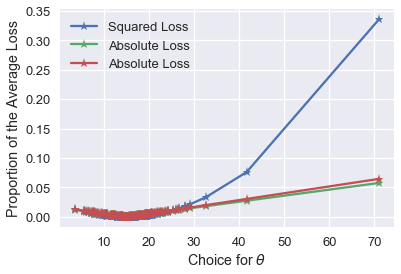

In [27]:
yobs = np.sort(data['pcttip'])
theta_est = 15.0

plt.plot(yobs, squared_loss(yobs, theta_est) / np.sum(squared_loss(yobs, theta_est)), '-*', label='Squared Loss')
plt.plot(yobs, abs_loss(yobs, theta_est) / np.sum(abs_loss(yobs, theta_est)), '-*', label='Absolute Loss')
plt.plot(yobs, huber_loss(yobs, theta_est) / np.sum(huber_loss(yobs, theta_est)), '-*', label='Absolute Loss')
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Proportion of the Average Loss")
plt.legend()
# plt.ylim([-7,15])
# plt.xlim([5,30])
plt.savefig("prop_loss.pdf")

In [28]:
yobs = np.sort(data['pcttip'])
theta_est = 15.0

lines = [ # Plot the Loss functions
    go.Scatter(x = yobs, y = squared_loss(yobs, theta_est) / np.sum(squared_loss(yobs, theta_est)) , 
               name='Squared Loss', mode='lines+markers'),
    go.Scatter(x = yobs, y = abs_loss(yobs, theta_est) / np.sum(abs_loss(yobs, theta_est)) , 
               name='Absolute Loss', mode='lines+markers'),
    go.Scatter(x = yobs, y = huber_loss(yobs, theta_est) / np.sum(huber_loss(yobs, theta_est)) , 
               name='Huber Loss', mode='lines+markers')
] 

# Assemble the plot
py.iplot(go.Figure(data = lines, 
                   layout=dict(xaxis=dict(title="Theta Values"),
                               yaxis=dict(title="Fraction of the Loss"))))

#### Observations:

Notice that the squared loss is much more sensitive to the far right data point than the Huber or Absolute loss functions.

---
<br/><br/>

## High Level Distinctions Between Loss Functions (so far)

1. The squared loss is sensitive to outliers but computationally convenient (more on that soon).
1. The absolute loss is much less sensitive to outliers but can be computationally challenging due to the corners.
1. The Huber loss is less sensitive to outliers and slightly easier to optimize than the absolute loss (smooth).

---
<br/><br/><br/> 

# Summary of the Model Design and Estimation (so far)

1. **Define the model:** This is usually based on intuition about the problem.  Try to keep models simple and introduce one or more parameters (e.g., $\theta$) that can be used to fit the model to data.
    <br/><br/>
1. **Define the objective/loss function:** This quantifies how well a model with a particular assignment for the parameters fits the data.
    1. So far we covered three loss functions: 
        1. *Squared ($L_2$) Loss*: common and easy to optimize -- sensitive to outliers
        1. *Absolute ($L_1$) Loss*: robust to outliers -- can be difficult to optimize 
        1. *Huber Loss*: robust to outliers and slightly easier to optimize.
    1. We will soon see that there are actually many more loss functions. 
    1. The choice of loss function will depend on the estimation task. 
    <br/><br/>
1. **Optimize the Loss Function:** Find the parameters $\theta$ that minimize the loss on the data. 
    1. So far we have done this graphically. 
    1. In the following we will explore computational and analytic approaches.

---
<br/><br/><br/> 

# Minimizing the Average Squared Loss Analytically 

In some cases, it is possible to use calculus to analytically compute the parameters $\theta$ that minimize the loss function.  In particular, the use of the squared loss can often lead to a simple closed form estimator.

Using our earlier definition for the squared loss and data we can state the formal estimator $\hat{\theta}$:

$$\Large
\hat{\theta} = \arg \min_{\theta} \frac{1}{n}\sum_{i=1}^n \left( \theta - y_i \right)^2
$$

To solve for the minimum of the loss function we will need to use some basic concepts from calculus.

## Quick Review of Calculus:

Suppose we wanted to minimize the function:

$$\Large 
f(\theta) = (\theta - 3)^2
$$

which looks like:

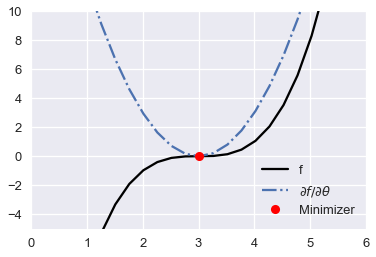

In [29]:
plt.plot(thetas, (thetas-3)**3,'k', label="f")
plt.plot(thetas, 3*(thetas-3)**2, '-.', label=r"$\partial f / \partial \theta$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.legend(); plt.ylim(-5,10); _= plt.xlim(0, 6)
plt.savefig("calc_cubic.pdf")

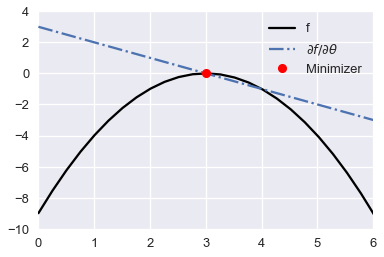

In [30]:
plt.plot(thetas, -(3-thetas)**2,'k', label="f")
plt.plot(thetas, (3-thetas), '-.', label=r"$\partial f / \partial \theta$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.legend(); plt.ylim(-10,4); _= plt.xlim(0, 6)
plt.savefig("calc_concave.pdf")

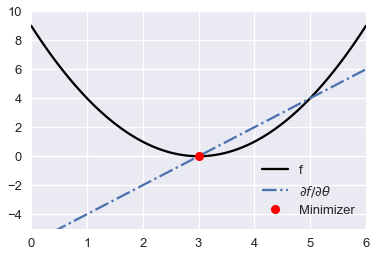

In [31]:
f = lambda theta: (theta - 3)**2
df = lambda theta: 2 * (theta - 3)
ddf = lambda theta: 2 * np.ones(theta.shape)
thetas = np.linspace(0, 6, 100)
plt.plot(thetas, f(thetas), 'k', label="f")
plt.plot(thetas, df(thetas), '-.', label=r"$\partial f / \partial \theta$")
# plt.plot(thetas, ddf(thetas), '--', label=r"$\partial^2 f / \partial \theta^2$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.legend(); plt.ylim(-5,10); _= plt.xlim(0, 6)
plt.savefig("calc_rev.pdf")

### Finding the extreme point

We can find extreme points (local maximum and minimum) of $f(\theta) = (\theta - 3)^2$ by taking the derivative:

$$\Large
\frac{\partial}{\partial \theta} f(\theta) = 2 (\theta - 3)
$$

and setting to zero and solving for $\theta$

\begin{align}
\Large
2 (\theta - 3) &= 
\Large 0 \\ 
\Large
\theta - 3 &= 
\Large 0 \\ 
\Large
\theta &= 
\Large 3 
\end{align}

Is this a minimum or a maximum.

### Minimum or maximum?

To determine if the extreme point is a minimum or a maximum we examine the second derivative: 

$$\Large
\frac{\partial^2}{\partial \theta^2} f(\theta) = 2 
$$

If the second derivative is **positive** at the extreme point (when the first derivative is negative) then the point is a maximum (the function is curved upwards). 

## Taking the derivative of the average loss:

To simplify notation we define the function that we want to minimize:

$$\Large
f(\theta) =  \frac{1}{n}\sum_{i=1}^n \left(y_i - \theta\right)^2
$$

and take the first derivative:

$$\Large
\frac{\partial}{\partial \theta} f(\theta) =  
-\frac{2}{n}\sum_{i=1}^n \left( y_i - \theta \right) 
$$

Setting the derivative equal to zero:

\begin{align}
0 &= -\frac{2}{n}\sum_{i=1}^n \left( y_i - \theta \right)   \\
0 &= \sum_{i=1}^n \left( y_i - \theta \right)  \\
0 &= \left(\sum_{i=1}^n y_i\right) - \left(\sum_{i=1}^n \theta\right)    \\
0 &= \left(\sum_{i=1}^n y_i\right) - n \theta     \\
n \theta  &= \sum_{i=1}^n y_i \\
\theta  &= \frac{1}{n} \sum_{i=1}^n y_i \\
\end{align}

Thus the value for $\theta$ that minimizes the average squared loss is:

$$\Large
\hat{\theta} = \frac{1}{n} \sum_{i=1}^n y_i \\
$$

## The minimizer is the **mean** of the observations!



---
<br/><br/><br/>

### Verify that this is the minimizer

While we have already graphically seen that the squared loss is curved upwards we can double check by taking the second derivative:


$$\Large
f(\theta) =  \frac{1}{n}\sum_{i=1}^n \left( \theta - y_i \right)^2
$$

$$\Large
\frac{\partial}{\partial \theta} f(\theta) =  
\frac{2}{n}\sum_{i=1}^n \left( \theta - y_i \right) 
$$


$$\Large
\frac{\partial^2}{\partial \theta^2} f(\theta) =  
\frac{2}{n}\sum_{i=1}^n 1 = 2
$$

which is positive when the derivative is zero (and indeed everywhere) and therefore our extreme point is a minimizer.

---
<br/><br/><br/> 

# Minimizing the Average Absolute Loss Analytically 

Minimize the absolute loss analytically can be a bit more challenging.  However for our simple constant models we can actually derive an expression for the optimal $\theta$

Just as with the average squared loss, we want to minimize:

$$\Large
f(\theta) = \frac{1}{n}\sum_{i=1}^n \left|  y_i - \theta \right|
$$

Just as before we take the first and second derivative of the loss function with respect to $\theta$.

### How do we take the derivative of the absolute value?


### Plotting the Derivatives

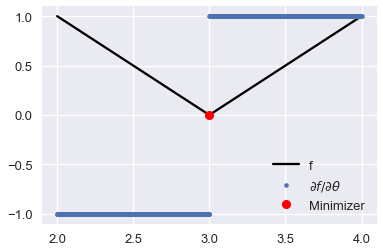

In [32]:
f = lambda theta: np.abs(3 - theta)
df = lambda theta: -np.sign(3 - theta)
ddf = lambda theta: np.zeros(theta.shape)
thetas = np.linspace(2, 4, 1000)
plt.plot(thetas, f(thetas), 'k', label="f")
plt.plot(thetas, df(thetas), '.', label=r"$\partial f / \partial \theta$")
# plt.plot(thetas, ddf(thetas), '--', label=r"$\partial^2 f / \partial \theta^2$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.legend(); 
plt.savefig("l1_deriv.pdf")



$$\Large
\frac{\partial}{\partial \theta} f(\theta) = \frac{1}{n}\sum_{i=1}^n \textbf{sign}(y_i -\theta)
$$

$$\Large
\frac{\partial^2}{\partial \theta^2} f(\theta) = 0
$$

**It is important to note that both of the above equations are not defined at $\theta = y_i$**

### Convention:

We will set set the sign of 0 to be zero implying that the gradient is zero for $\theta = y_i$: 

$$\Large
\textbf{sign}(0) = 0
$$

This is actually consistent with python:

In [33]:
np.sign(0)

0

## Setting the Derivative to Zero

While the derivative of the absolute value function is not defined around zero, we can define $\textbf{sign}(0) = 0$ and still attempt to find a $\theta$ value that sets the derivative to zero. 

Notice that we can rewrite the derivative as:

$$\Large
\frac{\partial}{\partial \theta} f(\theta) 
= -\frac{1}{n}\sum_{i=1}^n \textbf{sign}(y_i - \theta)
= -\frac{1}{n}\left( \sum_{y_i < \theta} -1 + \sum_{y_i > \theta} +1 \right)
$$

### What value of $\theta$ sets $\frac{\partial}{\partial \theta} f(\theta) = 0$?

$$\Large
 \frac{1}{n}\left( \sum_{y_i < \theta} -1 + \sum_{y_i > \theta} +1 \right) = 0
$$



Notice that we for the above equation to be zero we need the number of data points to the left of $\theta$ to equal the number of data points to the right of $\theta$.


## Illustration of Loss

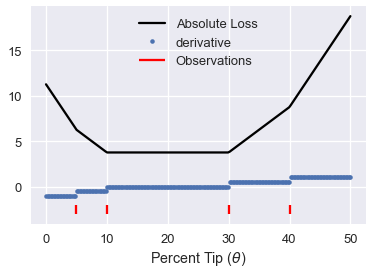

In [34]:
thetas = np.linspace(0, 50, 200)
x = np.array([5,10,30,40])
plt.plot(thetas, avg_loss(abs_loss, thetas, x)-10, '-k', label="Absolute Loss")
plt.plot(thetas, [np.mean(-np.sign(x - u)) for u in thetas], '.', label='derivative')
plt.vlines(x, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Percent Tip ($\theta$)')
plt.legend(loc=9)
plt.savefig("abslos_4.pdf")

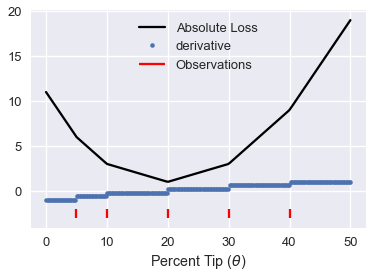

In [35]:
thetas = np.linspace(0, 50, 200)
x = np.array([5,10,20, 30,40])
plt.plot(thetas, avg_loss(abs_loss, thetas, x)-10, '-k', label="Absolute Loss")
plt.plot(thetas, [np.mean(-np.sign(x - u)) for u in thetas], '.', label='derivative')
plt.vlines(x, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Percent Tip ($\theta$)')
plt.legend(loc=9)
plt.savefig("abslos_5.pdf")

Notice that $\frac{\partial}{\partial \theta} f(\theta) $ is zero precisely when half of the data points are above and below $\theta$.  

### The median  of the data minimizes the average absolute loss!


$$\Large
\hat{\theta} = \arg\min_\theta \frac{1}{n}\sum_{i=1}^n \left| y_i - \theta \right| = \textbf{median}(\mathcal{D})
$$


---
<br/><br/><br/> 

# Minimizing the Average Huber Loss Analytically 

Recall that the Huber loss has the form:

$$\Large
f(\theta) =\frac{1}{n}\sum_{i=1}^n 
\begin{cases} 
      \frac{1}{2}\left( y_i - \theta \right)^2 & \left| y_i - \theta \right| < \alpha \\
       \alpha \left(\left| y_i - \theta  \right| - \frac{\alpha}{2} \right) & \text{otherwise}
\end{cases}
$$

Taking the derivative we get:

$$\Large
\frac{\partial}{\partial \theta} f(\theta) =\frac{1}{n}\sum_{i=1}^n 
\begin{cases} 
      -\left(y_i - \theta  \right) & \left| \theta - y_i \right| < \alpha \\
        -\alpha  \, \textbf{sign}(y_i - \theta) & \text{otherwise}
\end{cases}
$$

Unfortunately this is difficult to solve analytically. However we can get a plot of what the derivative looks like


### Derivative at a single point

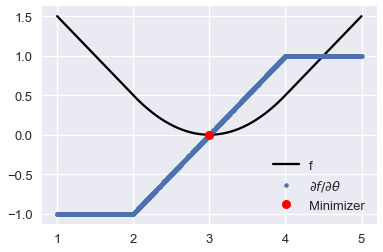

In [36]:
alpha =1.0
f = lambda theta: huber_loss(theta, 3, alpha = alpha)

def huber_loss_derivative(est, y_obs, alpha=1):
    d = abs_loss(est, y_obs)
    return np.where(d < alpha, 
                    est - y_obs,
                    alpha * np.sign(est-y_obs))

df = lambda theta: huber_loss_derivative(theta, 3.0, alpha=alpha)
thetas = np.linspace(1, 5, 1000)
plt.plot(thetas, f(thetas), 'k', label="f")
plt.plot(thetas, df(thetas), '.', label=r"$\partial f / \partial \theta$")
# plt.plot(thetas, ddf(thetas), '--', label=r"$\partial^2 f / \partial \theta^2$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.legend(); 

### Derivative on 4 and 5 test points. 

Notice that for the default $\alpha=1$ alpha value the curves look similar to the absolute loss but with smooth corners.

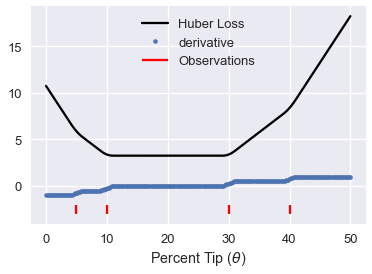

In [37]:
thetas = np.linspace(0, 50, 200)
x = np.array([5,10,30,40])
plt.plot(thetas, avg_loss(huber_loss, thetas, x)-10, '-k', label="Huber Loss")
plt.plot(thetas, avg_loss(huber_loss_derivative, thetas, x), '.', label='derivative')
plt.vlines(x, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Percent Tip ($\theta$)')
plt.legend(loc=9)
plt.savefig("huberloss_4.pdf")

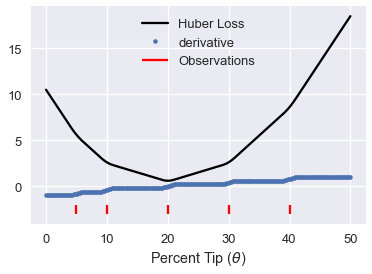

In [38]:
thetas = np.linspace(0, 50, 200)
x = np.array([5,10,20, 30,40])
plt.plot(thetas, avg_loss(huber_loss, thetas, x)-10, '-k', label="Huber Loss")
plt.plot(thetas, avg_loss(huber_loss_derivative, thetas, x), '.', label='derivative')
plt.vlines(x, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Percent Tip ($\theta$)')
plt.legend(loc=9)
plt.savefig("huberloss_5.pdf")

### Using a Different value for $\alpha$ and 4 test points

Notice in the following figure that the larger $\alpha$ value results in a unique estimator.

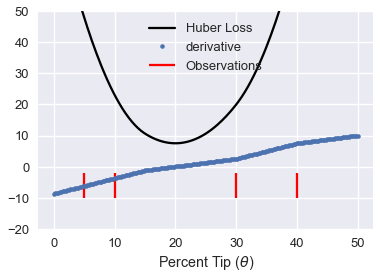

In [39]:
alpha = 10
huber_alpha = lambda a, b: huber_loss(a,b,alpha=alpha)
huber_derivative_alpha = lambda a, b: huber_loss_derivative(a,b,alpha)
thetas = np.linspace(0, 50, 200)
x = np.array([5,10,30,40])
plt.plot(thetas, avg_loss(huber_alpha, thetas, x)-80, '-k', label="Huber Loss")
plt.plot(thetas, avg_loss(huber_derivative_alpha, thetas, x), '.', label='derivative')
plt.vlines(x, -10, -2, colors="r", label="Observations")
plt.xlabel(r'Percent Tip ($\theta$)')
plt.ylim([-20,50])
plt.legend(loc=9)
plt.savefig("huberloss_4_alpha_10.pdf")

## Solving for the Numerical Minimizer

Because the loss function is smoother and convex, the Huber loss can be efficiently minimized **using convex optimization**.  

In [40]:
from scipy.optimize import minimize
f = lambda theta: data['pcttip'].apply(
    lambda y: huber_loss(theta, y)).mean()
df = lambda theta: data['pcttip'].apply(
    lambda y: huber_loss_derivative(theta, y)).mean()
minimize(f,0.0, jac=df)

      fun: 3.4999248461189802
 hess_inv: array([[ 5.08333333]])
      jac: array([  4.36809059e-17])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([ 15.53063381])

---
<br/><br/><br/>

# Improving the Model

So far we have taken a very simple model that the percentage tip is constant:

$$\Large
\text{percentage tip} = \theta
$$

We then defined several loss functions and used those to estimate the value of $\theta$.  How can we improve this model? Recall that we do have additional information:

In [41]:
data.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


### Question
What might be some alternative models:

1. $\Large \texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{total bill}$
1. $\Large \texttt{percentage tip} = \theta_1 * \texttt{(size < 4)} + \theta_2 * \texttt{(size >= 4)}$
1. $\Large \texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Dinner}$
1. $\Large \texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Female}$
1. $\Large \texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Male} + \theta_3 *\texttt{is Smoker} + \theta_4 * \texttt{table size}$


---
<br/><br/><br/> 

##  $\texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{total bill}$

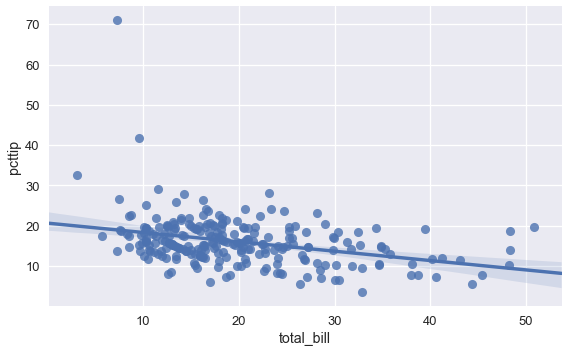

In [42]:
sns.lmplot(x = "total_bill", y = "pcttip", data = data, aspect=1.6)
plt.savefig("ptip_total_bill.pdf")

In [43]:
def f(theta, total_bill):
    return theta[0] + theta[1] * total_bill

In [44]:
def l2(theta):
    return np.mean(squared_loss(f(theta, data['total_bill']), data['pcttip']).values)

minimize(l2, np.array([0.0,0.0]))

      fun: 32.88596927218132
 hess_inv: array([[ 2.95408075, -0.12416698],
       [-0.12416698,  0.00627127]])
      jac: array([  0.00000000e+00,   4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([ 20.67658208,  -0.23230249])

In [45]:
def l1(theta):
    return np.mean(abs_loss(f(theta, data['total_bill']), data['pcttip']).values)

minimize(l1, np.array([0.0,0.0]))

      fun: 3.7712728395448254
 hess_inv: array([[ 619.60004604,  -23.55174969],
       [ -23.55174969,    0.90352092]])
      jac: array([-0.00032526, -0.06675968])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 480
      nit: 11
     njev: 117
   status: 2
  success: False
        x: array([ 18.75624561,  -0.16260019])

In [46]:
def huber(theta):
    return np.mean(huber_loss(f(theta, data['total_bill']), data['pcttip']))

minimize(huber, np.array([0.0,0.0]))

      fun: 3.3024895452509297
 hess_inv: array([[ 30.5492218 ,  -1.22160317],
       [ -1.22160317,   0.05944545]])
      jac: array([ -2.08616257e-07,  -5.51342964e-06])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([ 18.84706833,  -0.16844153])

---
<br/><br/><br/>

## $\texttt{percentage tip} = \theta_1 * \texttt{(size < 4)} + \theta_2 * \texttt{(size >= 4)}$

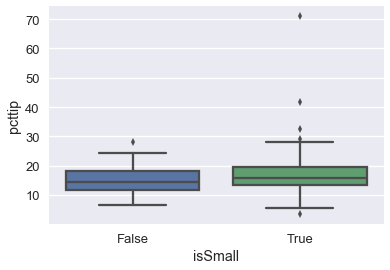

In [47]:
data['isSmall'] = data['size'] < 4
sns.boxplot(x = "isSmall", y = "pcttip", data = data)
plt.savefig("small_tables_model.pdf")

---
<br/><br/><br/>
## $\texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Dinner}$

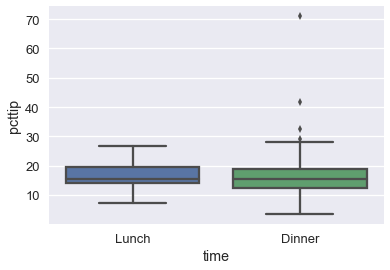

In [48]:
sns.boxplot(x = "time", y = "pcttip", data = data)
plt.savefig("isdinner_model.pdf")

---
<br/><br/><br/>

## $\texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Male} + \theta_3 *\texttt{is Smoker} + \theta_4 * \texttt{table size}$

In [49]:
data.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip,isSmall
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673,True
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159,True
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734,True
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041,True
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765,False


In [50]:
def f(theta, data):
    return (
        theta[0] + 
        theta[1] * (data['sex'] == 'Male') +
        theta[2] * (data['smoker'] == "Yes") +
        theta[3] * data['size']
    )

In [51]:
def l2(theta):
    return np.mean(squared_loss(f(theta, data), data['pcttip']).values)

minimize(l2, np.zeros(4))

      fun: 36.25888793122608
 hess_inv: array([[ 5.00852276, -1.03468734, -1.13297213, -1.36869473],
       [-1.03468734,  2.06166674,  0.00679159, -0.11857307],
       [-1.13297213,  0.00679159,  2.08462848,  0.14029876],
       [-1.36869473, -0.11857307,  0.14029876,  0.55080528]])
      jac: array([  3.81469727e-06,   3.33786011e-06,   4.76837158e-07,
         8.10623169e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([ 18.73866929,  -0.73513124,   0.16122391,  -0.87437012])

In [52]:
def l1(theta):
    return np.mean(abs_loss(f(theta, data), data['pcttip']).values)

minimize(l1, np.zeros(4))

      fun: 3.90957158852356
 hess_inv: array([[ 443.57329609, -215.55179077, -211.52560242, -109.7383045 ],
       [-215.55179077,  104.77953797,  102.80962477,   53.31466531],
       [-211.52560242,  102.80962477,  100.96345597,   52.31890909],
       [-109.7383045 ,   53.31466531,   52.31890909,   27.15457305]])
      jac: array([ 0.00750431,  0.00340596,  0.00340596,  0.01979941])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1104
      nit: 31
     njev: 182
   status: 2
  success: False
        x: array([ 18.02471408,  -0.72038142,  -0.9579457 ,  -0.77126898])

In [53]:
def huber(theta):
    return np.mean(huber_loss(f(theta, data), data['pcttip']))

minimize(huber, np.zeros(4))

      fun: 3.4476306812527757
 hess_inv: array([[ 77.24012512, -19.71060902, -26.073196  , -20.40690306],
       [-19.71060902,  20.85365616,   4.85116291,   2.01663757],
       [-26.073196  ,   4.85116291,  28.8990574 ,   5.65213441],
       [-20.40690306,   2.01663757,   5.65213441,   6.76874477]])
      jac: array([ -1.19209290e-07,  -8.94069672e-08,  -1.19209290e-07,
        -1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 150
      nit: 21
     njev: 25
   status: 0
  success: True
        x: array([ 18.53021329,  -0.90174037,  -0.87843472,  -0.84144212])

We could use the same loss framework as before and compute the best parameters for each model and then choose the model with the smallest average loss. 

_**Warning:** There are some issues with this approach that we will revisit later_